<a href="https://colab.research.google.com/github/williamratcliff/APS-GDS-March-2024-Data-Science-Tutorial/blob/main/Classification/Sound/Music_classifyer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
#https://drive.google.com/file/d/1LLeJeJDnCDCmrVnc-tvcuZDYVu10C9Vu/view?usp=drive_link
1LLeJeJDnCDCmrVnc-tvcuZDYVu10C9Vu
!wget --save-cookies cookies.txt --keep-session-cookies --no-check-certificate "https://docs.google.com/uc?export=download&id=1LLeJeJDnCDCmrVnc-tvcuZDYVu10C9Vu" -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p' > confirm && wget --load-cookies cookies.txt --no-check-certificate "https://docs.google.com/uc?export=download&confirm="$(cat confirm)"&id=1LLeJeJDnCDCmrVnc-tvcuZDYVu10C9Vu" -O arxiv.zip && rm cookies.txt confirm


In [18]:
!wget -O arxiv.zip https://www.dropbox.com/scl/fi/oepa8ps37h4mlm7n2rgpd/archive.zip?rlkey=mjeqp9mfazds4limk8mk69nud&dl=0

--2024-03-02 02:37:49--  https://www.dropbox.com/scl/fi/oepa8ps37h4mlm7n2rgpd/archive.zip?rlkey=mjeqp9mfazds4limk8mk69nud
Resolving www.dropbox.com (www.dropbox.com)... 162.125.67.18, 2620:100:6022:18::a27d:4212
Connecting to www.dropbox.com (www.dropbox.com)|162.125.67.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://uc08391fdf1ac36059172db3181a.dl.dropboxusercontent.com/cd/0/inline/COTAFk5xiQeM-BbwIvbvh9D3AiMwRQ5v3MbAMfvR5NbHAbz5KuUAQqC5XB4j6g6R2fjLsNnE7XRpwmZnkh6tGQyp-pICLwEzGT4YCiyqZA-lkuZtSAZEcqTxBJ0Hcjt0l3E/file# [following]
--2024-03-02 02:37:50--  https://uc08391fdf1ac36059172db3181a.dl.dropboxusercontent.com/cd/0/inline/COTAFk5xiQeM-BbwIvbvh9D3AiMwRQ5v3MbAMfvR5NbHAbz5KuUAQqC5XB4j6g6R2fjLsNnE7XRpwmZnkh6tGQyp-pICLwEzGT4YCiyqZA-lkuZtSAZEcqTxBJ0Hcjt0l3E/file
Resolving uc08391fdf1ac36059172db3181a.dl.dropboxusercontent.com (uc08391fdf1ac36059172db3181a.dl.dropboxusercontent.com)... 162.125.70.15, 2620:100:6021:15::a27d:410f
Connecting to uc0

In [19]:
!unzip arxiv.zip

Archive:  arxiv.zip
   creating: archive/
   creating: archive/Data/
  inflating: archive/Data/features_30_sec.csv  
  inflating: archive/Data/features_3_sec.csv  
   creating: archive/Data/genres_original/
   creating: archive/Data/genres_original/blues/
  inflating: archive/Data/genres_original/blues/blues.00000.fft.npy  
  inflating: archive/Data/genres_original/blues/blues.00000.wav  
  inflating: archive/Data/genres_original/blues/blues.00001.fft.npy  
  inflating: archive/Data/genres_original/blues/blues.00001.wav  
  inflating: archive/Data/genres_original/blues/blues.00002.fft.npy  
  inflating: archive/Data/genres_original/blues/blues.00002.wav  
  inflating: archive/Data/genres_original/blues/blues.00003.fft.npy  
  inflating: archive/Data/genres_original/blues/blues.00003.wav  
  inflating: archive/Data/genres_original/blues/blues.00004.fft.npy  
  inflating: archive/Data/genres_original/blues/blues.00004.wav  
  inflating: archive/Data/genres_original/blues/blues.00005.fft.

<Figure size 640x480 with 0 Axes>

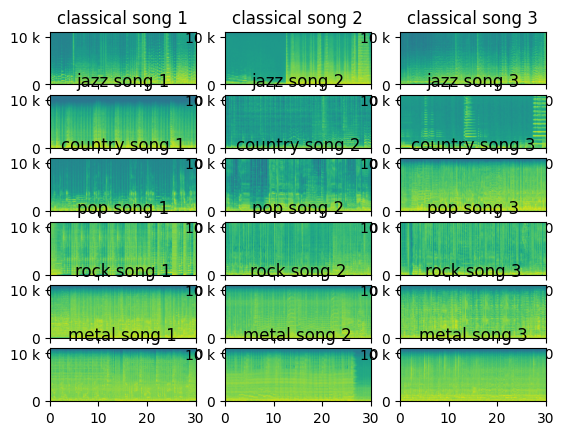

In [22]:
from fft import plot_specgrams

plot_specgrams()


In [23]:
import numpy as np
from collections import defaultdict
import seaborn as sns

from sklearn.metrics import precision_recall_curve, roc_curve
from sklearn.metrics import auc
#from sklearn.cross_validation import ShuffleSplit
from sklearn.model_selection import ShuffleSplit
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.preprocessing import StandardScaler

from utils import plot_pr, plot_roc, plot_confusion_matrix, GENRE_LIST

from fft import read_fft

genre_list = GENRE_LIST

In [24]:
def train_model(clf_factory, X, Y, name, plot=False):
    labels = np.unique(Y)
    #try scaling our data
    scaler = StandardScaler()
    X= scaler.fit_transform(X)

    cv = ShuffleSplit(n_splits=len(X), test_size=0.3, random_state=0)
    #Should this be StartifiedShuffleSplit?
    train_errors = []
    test_errors = []

    scores = []
    pr_scores = defaultdict(list)
    precisions, recalls, thresholds = defaultdict(
        list), defaultdict(list), defaultdict(list)

    roc_scores = defaultdict(list)
    tprs = defaultdict(list)
    fprs = defaultdict(list)

    clfs = []  # just to later get the median

    cms = []

    for train, test in cv.split(X):
        X_train, y_train = X[train], Y[train]
        X_test, y_test = X[test], Y[test]

        clf = clf_factory()
        clf.fit(X_train, y_train)
        clfs.append(clf)

        train_score = clf.score(X_train, y_train)
        test_score = clf.score(X_test, y_test)
        scores.append(test_score)

        train_errors.append(1 - train_score)
        test_errors.append(1 - test_score)

        y_pred = clf.predict(X_test)
        cm = confusion_matrix(y_test, y_pred)
        cms.append(cm)

        for label in labels:
            y_label_test = np.asarray(y_test == label, dtype=int)
            proba = clf.predict_proba(X_test)
            proba_label = proba[:, label]

            precision, recall, pr_thresholds = precision_recall_curve(
                y_label_test, proba_label)
            pr_scores[label].append(auc(recall, precision))
            precisions[label].append(precision)
            recalls[label].append(recall)
            thresholds[label].append(pr_thresholds)

            fpr, tpr, roc_thresholds = roc_curve(y_label_test, proba_label)
            roc_scores[label].append(auc(fpr, tpr))
            tprs[label].append(tpr)
            fprs[label].append(fpr)

    if plot:
        for label in labels:
            print("Plotting %s" % genre_list[label])
            scores_to_sort = roc_scores[label]
            median = np.argsort(scores_to_sort)[int(len(scores_to_sort) / 2)]

            desc = "%s %s" % (name, genre_list[label])
            plot_pr(pr_scores[label][median], desc, precisions[label][median],
                    recalls[label][median], label='%s vs rest' % genre_list[label])
            plot_roc(roc_scores[label][median], desc, tprs[label][median],
                     fprs[label][median], label='%s vs rest' % genre_list[label])

    all_pr_scores = np.array(list(pr_scores.values())).flatten()
    summary = (np.mean(scores), np.std(scores),
               np.mean(all_pr_scores), np.std(all_pr_scores))
    print("%.3f\t%.3f\t%.3f\t%.3f\t" % summary)

    return np.mean(train_errors), np.mean(test_errors), np.asarray(cms)


In [25]:
def create_model():
    from sklearn.linear_model import LogisticRegression
    clf = LogisticRegression(n_jobs=8, max_iter=50)
    return clf

Plotting classical


Plotting jazz


Plotting country


Plotting pop


Plotting rock


Plotting metal


0.502	0.032	0.481	0.172	


<Figure size 640x480 with 0 Axes>

<Figure size 500x400 with 0 Axes>

<Figure size 500x400 with 0 Axes>

<Figure size 500x400 with 0 Axes>

<Figure size 500x400 with 0 Axes>

<Figure size 500x400 with 0 Axes>

<Figure size 500x400 with 0 Axes>

<Figure size 500x400 with 0 Axes>

<Figure size 500x400 with 0 Axes>

<Figure size 500x400 with 0 Axes>

<Figure size 500x400 with 0 Axes>

<Figure size 500x400 with 0 Axes>

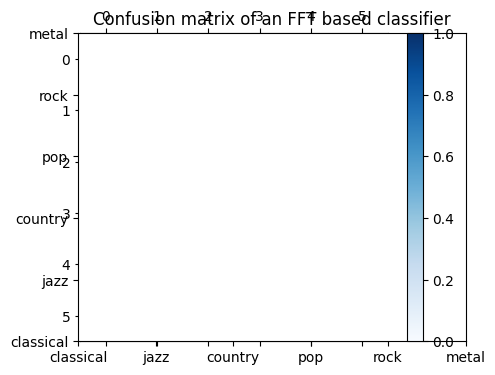

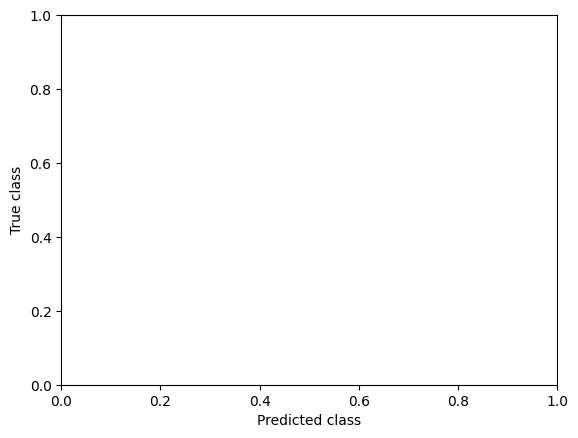

In [26]:
X, y = read_fft(genre_list)
train_avg, test_avg, cms = train_model(create_model, X, y, "Log Reg FFT", plot=True)
cm_avg = np.mean(cms, axis=0)
cm_norm = cm_avg / np.sum(cm_avg, axis=0)
plot_confusion_matrix(cm_norm, genre_list, "fft", "Confusion matrix of an FFT based classifier")

